In [2]:
import torchtext.data as data
from torchtext.data import BucketIterator

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from torch_struct import LinearChainCRF
#import matplotlib
import matplotlib.pyplot as plt

class ConllXDataset(data.Dataset):
    def __init__(self, path, fields, encoding='utf-8', separator='\t', **kwargs):
        examples = []
        columns = [[], []]
        column_map = {1: 0, 3: 1}
        with open(path, encoding=encoding) as input_file:
            for line in input_file:
                line = line.strip()
                if line == '':
                    examples.append(data.Example.fromlist(columns, fields))
                    columns = [[], []]
                else:
                    for i, column in enumerate(line.split(separator)):
                        if i in column_map:
                            columns[column_map[i]].append(column)
            examples.append(data.Example.fromlist(columns, fields))
        super(ConllXDataset, self).__init__(examples, fields, **kwargs)

#to do: add bos
WORD = data.Field() # init_token='<bos>', eos_token='<eos>'
POS = data.Field(is_target=True)
fields = (('word', WORD), ('pos', POS))

train = ConllXDataset('/Users/sofia/pytorch-struct/examples/data/sam.conllu', fields)

WORD.build_vocab(train)
POS.build_vocab(train)
#print(vars(POS.vocab))

train_iter = BucketIterator(train, batch_size=2, device='cpu', shuffle=False)

C = len(POS.vocab.itos)
V = len(WORD.vocab.itos)
C, V

(6, 7)

In [3]:
print(vars(POS.vocab))

{'freqs': Counter({'PRON': 5, 'AUX': 5, 'PUNCT': 5, 'PROPN': 4}), 'itos': ['<unk>', '<pad>', 'AUX', 'PRON', 'PUNCT', 'PROPN'], 'unk_index': 0, 'stoi': defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x11fde6f50>>, {'<unk>': 0, '<pad>': 1, 'AUX': 2, 'PRON': 3, 'PUNCT': 4, 'PROPN': 5}), 'vectors': None}


In [4]:
class Model(nn.Module):
    def __init__(self, voc_size, num_pos_tags):
        super().__init__()
        self.linear = nn.Linear(voc_size, num_pos_tags)

    def forward(self, count_mat):
        #print(self.linear(count_mat).shape)
        return F.log_softmax(self.linear(count_mat), dim=2)

model = Model(V, C)
#loss_function = nn.MSELoss()
opt = optim.SGD(model.parameters(), lr=.7)

In [5]:
def show_chain(chain):

    plt.imshow(chain.detach().sum(-1).transpose(0, 1))

In [6]:
model.train()
#losses = []
for epoch in range(2):
    print(epoch)
    for batch in train_iter:
            #model.zero_grad()
        opt.zero_grad() 

        dims_fake = torch.full((batch.pos.shape[1], C, V), .3)
        #print(dims_fake)
        #print(dims_fake.requires_grad)
        #model_in = make_count_mat(batch.word, batch.pos)

        probs = model(dims_fake)
#         print('probs', probs)
#         #print('weights', model.linear.weight)
#         print('parms', list(model.parameters()))
        
        chain = probs.unsqueeze(1).expand(-1, batch.word.shape[0]-1, -1, -1)  # batch, N, C, C 
        #print(chain)
        
        dist = LinearChainCRF(chain) # f(y) = \prod_{n=1}^N \phi(n, y_n, y_n{-1}) 
        #print('d', dist.marginals.shape, dist.marginals)
        # print(dist.argmax.shape) 
#         show_chain(dist.argmax[0])
#         plt.show()


        label = batch.pos
        labels = LinearChainCRF.struct.to_parts(label.transpose(0, 1) \
                            .type(torch.LongTensor), C).type(torch.FloatTensor) # b x N, C -> b x (N-1) x C x C 
#         out = LinearChainCRF(labels)
#         show_chain(out.argmax[0])
#         plt.show()    
        #print('l', labels.shape, labels)

        #print(dist.log_prob(labels))
        loss = dist.log_prob(labels).sum() # (*sample_shape x batch_shape x event_shape*) -> (*sample_shape x batch_shape*)  
        (-loss).backward()
        print(loss)
        
        #print(model.linear.weight.grad)
        
        opt.step()
            
        #print(dist.log_prob(dist.marginals))
        #print(loss.detach())
        # losses.append(loss.detach())

0
tensor(-14.2392, grad_fn=<SumBackward0>)
tensor(-14.1560, grad_fn=<SumBackward0>)
tensor(-6.9815, grad_fn=<SumBackward0>)
1
tensor(-13.9063, grad_fn=<SumBackward0>)
tensor(-13.9370, grad_fn=<SumBackward0>)
tensor(-6.8834, grad_fn=<SumBackward0>)


epoch 10 batch 0


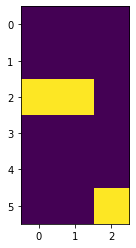

tensor(13.4721, grad_fn=<NegBackward>)


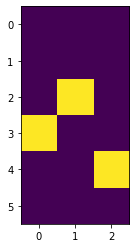

epoch 10 batch 1


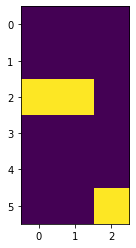

tensor(13.5526, grad_fn=<NegBackward>)


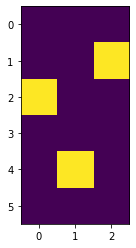

epoch 10 batch 2


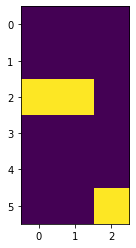

tensor(6.7364, grad_fn=<NegBackward>)


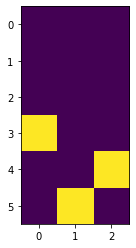

epoch 110 batch 0


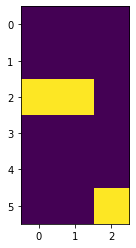

tensor(13.4719, grad_fn=<NegBackward>)


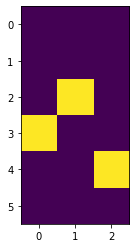

epoch 110 batch 1


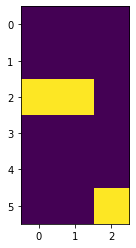

tensor(13.5527, grad_fn=<NegBackward>)


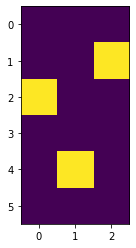

epoch 110 batch 2


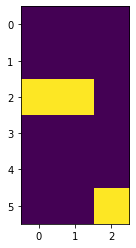

tensor(6.7363, grad_fn=<NegBackward>)


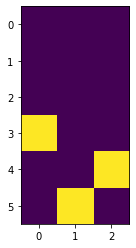

epoch 210 batch 0


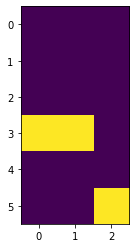

tensor(13.4718, grad_fn=<NegBackward>)


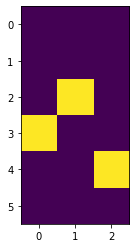

epoch 210 batch 1


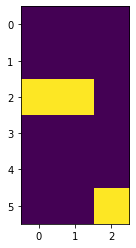

tensor(13.5527, grad_fn=<NegBackward>)


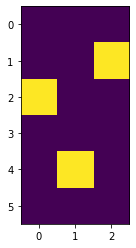

epoch 210 batch 2


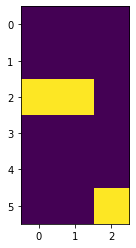

tensor(6.7363, grad_fn=<NegBackward>)


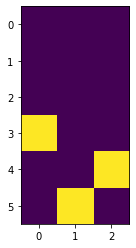

In [17]:
model.train()
#losses = []
for epoch in range(300):
    #print(epoch)
    for i, batch in enumerate(train_iter):
        opt.zero_grad() 

        dims_fake = torch.full((batch.pos.shape[1], C, V), .3)
        #model_in = make_count_mat(batch.word, batch.pos)

        probs = model(dims_fake)
#         print('probs', probs)
#         print('parms', list(model.parameters()))
        
        chain = probs.unsqueeze(1).expand(-1, batch.word.shape[0]-1, -1, -1)  # batch, N, C, C 
        #print(chain)
        
        dist = LinearChainCRF(chain) # f(y) = \prod_{n=1}^N \phi(n, y_n, y_n{-1}) 
        #print('d', dist.marginals.shape, dist.marginals)
        # print(dist.argmax.shape) 
#         show_chain(dist.argmax[0])
#         plt.show()

        label = batch.pos
        labels = LinearChainCRF.struct.to_parts(label.transpose(0, 1) \
                            .type(torch.LongTensor), C).type(torch.FloatTensor) # b x N, C -> b x (N-1) x C x C 
        out = LinearChainCRF(labels)
#         show_chain(out.argmax[0])
#         plt.show()    
        #print('l', labels.shape, labels)

        #print(dist.log_prob(labels))
        loss = dist.log_prob(labels).sum() # (*sample_shape x batch_shape x event_shape*) -> (*sample_shape x batch_shape*)  
        (-loss).backward()
        #print(loss)       
        #print(model.linear.weight.grad)
        
        opt.step()
        
        if epoch % 100 == 10:  
            print('epoch', epoch, 'batch', i)
            show_chain(dist.argmax[0])  
            plt.show()
            show_chain(out.argmax[0])
            print(-loss)
            plt.show()
        #print(dist.log_prob(dist.marginals))
        #print(loss.detach())
        # losses.append(loss.detach())

